# （完成版）自動計測

## 処理手順

### 1. 輪郭線仮分割　preGetLRdata, segmentLR0
画像は、概ね縦におかれた状態とする。
輪郭線抽出後、上５％、下５％をカットすることにより輪郭線を左右に分ける。これを輪郭セグメントと呼ぶことにする。
対象が上部で斜めになっている場合、対称形であっても左右で切り出される部分が異なることになる。

![Alt text](https://monosnap.com/image/cK9wq7yvqA5MkedGmEYFEVCfKnWKEc.png)

### 2. 輪郭セグメントにベジエ曲線あてはめ(1) cntPair2bez
この時点では上端下端での対象の大まかな傾きを求めるのが目的なのでサンプル数や次数（M)は最終的なそれより少なめでも構わない。

左右の輪郭セグメントからサンプリングした点集合にベジエ曲線をあてはめ、得られた左右の関数表現を平均して得られる関数で表される曲線を仮の中心軸とする。

２つのベジエ曲線の平均は、両者の制御点の中点を制御点とするベジエ曲線である。

- 左右の輪郭セグメントが線対称でれば、得られる曲線は対称軸に一致し、これは対象の中心軸と言って良い。
-　左右の輪郭セグメントの全体あるいは平行な部分は中心軸に一致する。
- 曲率の変化に大きな差があると本来の中心軸と差が大きい。差が少なければ、中心軸と大きくかけ離れることはない。

ここで、正しい中心軸は、次の性質を満足する曲線であると考えている。
- その曲線上の任意の点が、その点におけるその曲線の垂線と左右の輪郭の交点の中点となる。

### 3. 輪郭線の再分割　reGetCntPair
1の処理はY軸に垂直な直線で輪郭をカットしたが、今度は仮中心軸の傾きに垂直な直線で輪郭をカットすることで輪郭を左右の輪郭セグメントに分割する。  
（プログラムでは、仮中心線の延長上に中心をもつ大きな円で輪郭をカットしているが、実質的には同じ）

この際、
- 端点付近では近似曲線と真の中心軸と乖離している程度が大きい、かつ、
- パラメータ０、１付近の微係数は異常値を取ることが多い
ため、０、１ではなく、０.１、０.９の位置での傾きを利用する。

### 4. 輪郭セグメントにベジエ曲線あてはめ(2)  cntPair2bez
左右の近似曲線を最終決定するあてはめなので、１回目よりサンプル数を増やしし、必要かつ最低限の近似次数（N)で近似する。

### 5.  calcWidthFunc, getcenterBez


In [1]:
from sympy import *
from sympy.abc import a,b,c
import numpy as np
import cv2
%matplotlib inline
from sympy import var
from rdlib2 import *
UNIT = 256

kohaku='シルエット/17Cylindric/17kohaku1o09_l.jpg'
yakumi ='シルエット/17Spheric/17yakumi2o06_l.jpg'
daruma='シルエット/17Apically/17daruma6o06_l.jpg'
aomida='シルエット/17Horn/17aomida1o02_l.jpg'
test='シルエット/17Apically/17daruma1o03_l.jpg'
test1='シルエット/17Apically/17daruma1o08_l.jpg'

kohakuimg = getstandardShape(cv2.imread(kohaku,cv2.IMREAD_GRAYSCALE), unitSize=UNIT,showResult=False)  
yakumiimg = getstandardShape(cv2.imread(yakumi,cv2.IMREAD_GRAYSCALE), unitSize=UNIT,showResult=False)  
darumaimg = getstandardShape(cv2.imread(daruma,cv2.IMREAD_GRAYSCALE), unitSize=UNIT,showResult=False)  
aomidaimg = getstandardShape(cv2.imread(aomida,cv2.IMREAD_GRAYSCALE), unitSize=UNIT,showResult=False)  
testimg = getstandardShape(cv2.imread(test,cv2.IMREAD_GRAYSCALE), unitSize=UNIT,showResult=False)  

imgs=[kohakuimg,yakumiimg,darumaimg,aomidaimg,testimg]

IPython console for SymPy 1.2 (Python 3.6.6-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.2/



In [18]:
# ベジエ曲線あてはめ、仮中心線の抽出
def preGetLRdata(img,tlevel = 10, blevel=90,bracket=1):
    #  輪郭を抽出
    _img,contours,hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    # バウンダリ矩形を得る
    x0,y0,w,h = cv2.boundingRect(img)
    cnt = contours[0] # 白領域は１つしかないという前提なので、０番の輪郭が大根の輪郭である。
    # 閉じた輪郭線の上下を削り、左右２本の輪郭に分割する
    canvas = np.zeros_like(img)  # 描画キャンバスの準備
    canvas = cv2.drawContours(canvas, contours, -1, 255, thickness=1)     # 輪郭線の描画
    # 上下端それぞれ10％をカットする。上下は歪みが大きいのでノイズとなるので 削除するとともに、それにより輪郭を左右分割する。
    cutHead= y0+int(tlevel*h/100) # シルエッ上端から指定％の高さ
    cutBottom = y0+int(blevel*h/100) # シルエッ下端から指定％の高さ
    canvas[0:cutHead,:]=np.zeros((cutHead,img.shape[1])) # 上5%をマスク
    canvas[cutBottom+1:,:]=np.zeros((img.shape[0]-(cutBottom+1),img.shape[1]))  # 下5%をマスク
    cntl,cntr = segmentLR0(canvas,bracket=bracket)
    return cntl,cntr,cnt
    
# 左右セグメントを含む画像から左右の輪郭をえる
def segmentLR0(img,bracket=2):
    # bracket    2 : cv2 の輪郭データそのまま（２重カッコ）、 1: カッコを１つ外したリストを返す
    # 輪郭検出すれば２つの輪郭が見つかるはず。
    _, contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 線図形の輪郭は中間で折り返しになっている
    cnt0 = contours[0][:int(len(contours[0])/2+1)]
    cnt1 = contours[1][:int(len(contours[1])/2+1)]
    # 中程の点を比べて左にある方を左と判定する。
    c0 = cnt0[int(len(cnt0)/2)][0][0]
    c1 = cnt1[int(len(cnt1)/2)][0][0]
    if  c0 > c1: 
        cntl,cntr = cnt1,cnt0
    else:
        cntr,cntl = cnt1,cnt0
        
    def bracket2to1(cnt):    
        cnt = np.array([[x,y] for [[x,y]] in cnt])
        return cnt
    
    if bracket == 2:
        return cntl,cntr
    else:
        return bracket2to1(cntl),bracket2to1(cntr)

# 左右の輪郭点をベジエ近似する
def cntPair2bez(cntl,cntr,N=3,n_samples=20,precPara=0.01,openmode=False, debugmode=False, showImage=False):
    # 輪郭点を（チェインの並び順に）等間隔に n_samples 個サンプリングする。
    cntL = cntl[np.array(list(map(int,np.linspace(0, len(cntl)-1,n_samples))))]
    cntR = cntr[np.array(list(map(int,np.linspace(0, len(cntr)-1,n_samples))))]
    
    # 左右をそれぞれベジエ 曲線で近似し、その平均として中心軸を仮決定
    datal = cpxl,cpyl,bezXl,bezYl,tpl = fitBezierCurveN(cntL,precPara=precPara,N=N,openmode=openmode,debugmode=debugmode)
    datar = cpxr,cpyr,bezXr,bezYr,tpr = fitBezierCurveN(cntR,precPara=precPara,N=N,openmode=openmode,debugmode=debugmode)
    bezXc,bezYc = (bezXl+bezXr)/2,(bezYl+bezYr)/2
    cpl,cpr,cpc = (cpxl,cpyl),(cpxr,cpyr),((cpxl+cpxr)/2,(cpyl+cpyr)/2)
    bezL,bezR,bezC = (bezXl,bezYl),(bezXr,bezYr),(bezXc,bezYc)
    return cpl,cpr,cpc, bezL,bezR,bezC,cntL,cntR
    
# 結果の描画
def drawBez2(img,bezL=None,bezR=None,bezC=None,cpl=None,cpr=None,cpc=None, 
             cntL=[],cntR=[],cntC=None, ladder=None,PosL=[],PosR=[],PosC=[],n_samples=20):
    bezXl,bezYl = bezL if bezL != None else ([],[])
    bezXr,bezYr = bezR if bezR != None else ([],[])
    bezXc,bezYc = bezC if bezC != None else ([],[])
    cpxl,cpyl = cpl if cpl != None else ([],[])
    cpxr,cpyr = cpr if cpr != None else ([],[])
    cpxc,cpyc = cpc if cpc != None else ([],[])
    tplins50 = np.linspace(0, 1, 50)
    tplinsSP = np.linspace(0, 1, n_samples)
    
    plt.figure(figsize=(6,6),dpi=100)
    plt.gca().invert_yaxis() 
    plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
    plt.imshow(192+(cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)/4).astype(np.uint8))
    # 左輪郭の描画
    if bezL != None:
        plotx = [bezXl.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYl.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
    if len(cntL) >0:
        plt.scatter(cntL[:,0],cntL[:,1],color ='blue',marker = '.') #  サンプル点
    if cpl != None:
        plt.scatter(cpxl,cpyl,color ='purple',marker = '*') #  制御点の描画
        for i in range(len(cpxl)) : plt.annotate(str(i),(cpxl[i],cpyl[i]))
    # 右輪郭の描画
    if bezR != None:
        plotx = [bezXr.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYr.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
    if len(cntR)  > 0:
        plt.scatter(cntR[:,0],cntR[:,1],color ='blue',marker = '.') #  サンプル点
    if cpr != None:
        plt.scatter(cpxr,cpyr,color ='red',marker = '*') #  制御点の描画
        for i in range(len(cpxr)):plt.annotate(str(i),(cpxr[i],cpyr[i]))
    # 中心軸の描画
    if bezC != None:
        plotx = [bezXc.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYc.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        if cntC != None:
            plt.scatter(cntc[:,0],cnc[:,1],color ='blue',marker = '.') #  サンプル点
        if cpc != None:
            plt.scatter(cpxc,cpyc,color ='darkgreen',marker = '*') #  制御点の描画
            for i in range(len(cpxc)):plt.annotate(str(i),(cpxc[i],cpyc[i]))
                
        # ラダーの描画
        if  ladder== 'lr':  # 左右の同じパラメータ値の点を結ぶだけ
            plotSPlx = [bezXl.subs(t,tp) for tp in tplinsSP ]
            plotSPly = [bezYl.subs(t,tp) for tp in tplinsSP ]
            plotSPrx = [bezXr.subs(t,tp) for tp in tplinsSP ]
            plotSPry = [bezYr.subs(t,tp) for tp in tplinsSP ]       
            for x0,x1,y0,y1 in zip(plotSPlx,plotSPrx,plotSPly,plotSPry):
                plt.plot([x0,x1],[y0,y1],color = 'orange') 
                
        elif ladder == 'normal':
            # 中心軸上に設定したサンプル点における法線と両輪郭の交点のリストを求める。
            plot20lx = [xl if xl !=np.inf else [] for [xl,yl] in PosL ]
            plot20ly = [yl if yl !=np.inf else [] for [xl,yl] in PosL]
            #plot20cx = [bezXc.subs(t,tp) for tp in np.linspace(0, 1, n_samples) ]
            #plot20cy = [bezYc.subs(t,tp) for tp in np.linspace(0, 1, n_samples) ]
            plot20cx = PosC[:,0]
            plot20cy = PosC[:,1]
            plot20rx = [xr if xr !=np.inf else [] for [xr,yr] in PosR ]
            plot20ry = [yr if yr !=np.inf else [] for [xr,yr] in PosR ]
                  
            for x0,x1,y0,y1 in zip(plot20lx,plot20cx,plot20ly,plot20cy):
                if x0 != [] and y0 !=[]:
                    plt.plot([x0,x1],[y0,y1],color = 'orange') 
            for x0,x1,y0,y1 in zip(plot20rx,plot20cx,plot20ry,plot20cy):
                if x0 != [] and y0 !=[]:
                    plt.plot([x0,x1],[y0,y1],color = 'orange') 
    
# 中心軸ベジエをもとにそれに輪郭点を左右に分割する
def reGetCntPair(img,cnt,cpl,cpr,bezC,CAPCUT=0,TAILCUT=0):
    xLu,xRu,yLu,yRu = cpl[0][0],cpr[0][0],cpl[0][1],cpr[0][1] # 近似曲線の上端の座標
    xLb,xRb,yLb,yRb = cpl[0][0],cpr[0][0],cpl[0][1],cpr[0][1] # 近似曲線の上端の座標
    bezXc,bezYc = bezC
    # 輪郭線の描画
    canvas = np.zeros_like(img)
    canvas = cv2.drawContours(canvas, cnt, -1, 255, thickness=1)
    # 軸と輪郭の交点
    (crpx0,crpy0),(crpx1,crpy1) = crossPoints(img,cnt,bezC)
    
    # 中心軸の延長で上端から最大径離れた地点を中心に最大直径より少し大きな円を０で描き輪郭を削る。
    dy = float((diff(bezYc,t)).subs(t,0.1))
    dx = float((diff(bezXc,t)).subs(t,0.1)) # t=0 は境界なので変な値にあることがあるため 0.1 としている
    dd = np.sqrt(dx*dx+dy*dy)
    dkusabi = (xRu-xLu)*abs(dx)/dd/2
    acc = dy/dx if dx != 0 else np.inf # 中心軸の傾き
    x00 = bezXc.subs(t,0) #  軸の再上端
    y00 = bezYc.subs(t,0)
    ddd = sqrt((crpx0-x00)**2+(crpy0-y00)**2) # ベジエ軸上端と輪郭上端の距離
    #dddd = 5*(ddd-dkusabi)**2*((ddd-dkusabi)*dy/dd/(xRu-xLu) -0.1)
    dddd = -10 if ddd/(xRu-xLu) < 0.2 else  ddd-dkusabi 
    if CAPCUT != 0: # 特別指定された削除調整量がある場合
        dddd = -CAPCUT
    diaMinus =  1024
    xdd = diaMinus*dx/sqrt(dx**2+dy**2) #  1024離れるためのX移動量
    dia = diaMinus-dddd # 
    x11 = x00-xdd
    y11 =  y00-xdd*acc if acc != np.inf else y00-diaMinus
    canvas =  cv2.circle(canvas,(int(x11),int(y11)),int(dia),0,-1) # 黒で円を描いて削る
    # 同様に下端を削る
    dy = float((diff(bezYc,t)).subs(t,0.9))
    dx = float((diff(bezXc,t)).subs(t,0.9)) # t=1 は境界なので変な値にあることがあるため 0.9 としている
    dd = np.sqrt(dx*dx+dy*dy)
    dkusabi = (xRb-xLb)*abs(dx)/dd/2
    acc = dy/dx if dx != 0 else np.inf # 中心軸の傾き
    x00 = bezXc.subs(t,1) #  軸の再下端
    y00 = bezYc.subs(t,1)
    xdd = diaMinus*dx/sqrt(dx**2+dy**2) # 
    ddd = sqrt((crpx1-x00)**2+(crpy1-y00)**2) # ベジエ軸下端と輪郭下端の距離
    dddd = -10 if (xRu-xLu)/(xRb-xLb) > 4  else  ddd-dkusabi 
    if TAILCUT != 0: # 特別指定された削除調整量がある場合
        dddd = -TAILCUT
    dia = diaMinus-dddd
    x11 = x00+xdd
    y11 =  y00+xdd*acc if acc != np.inf else y00+diaMinus
    canvas =  cv2.circle(canvas,(int(x11),int(y11)),int(dia),0,-1) # 黒で円を描いて削る
    
    # 輪郭検出すれば２つの輪郭が見つかるはず。
    _, contours, hierarchy = cv2.findContours(canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 線図形の輪郭は中間で折り返しになっている
    cnt0 = contours[0][:int(len(contours[0])/2+1)]
    cnt1 = contours[1][:int(len(contours[1])/2+1)]
    # 中程の点を比べて左にある方を左と判定する。
    c0 = cnt0[int(len(cnt0)/2)][0][0]
    c1 = cnt1[int(len(cnt1)/2)][0][0]
    if  c0 > c1: 
        cntL,cntR = cnt1,cnt0
    else:
        cntR,cntL = cnt1,cnt0
    print("左輪郭点の数 ", len(cntL),"　右輪郭点の数　", len(cntR))
    #  ２重かっこを１重に変換し、numpy array にしてから返す
    cntL = np.array([[x,y] for [[x,y]] in cntL])
    cntR = np.array([[x,y] for [[x,y]] in cntR])                
    return cntL,cntR,(crpx0,crpy0),(crpx1,crpy1)

# 上端、下端の削られた部分と中心線の交点を求める
def crossPoints(img,cnt,bezC):
        bezXc,bezYc = bezC
        canvas1 = np.zeros_like(img)  # 描画キャンバスの準備
        canvas2 = canvas1.copy()
        canvas1 = cv2.drawContours(canvas1, cnt, -1, 1, thickness=1)     # 輪郭線の描画
        
        # 中心軸上端から、軸の延長方向に直線を描く
        y0 = float(bezYc.subs(t,0.)) # 上端の座標
        x0 = float(bezXc.subs(t,0.))
        dx = float(diff(bezXc,t).subs(t,0.1)) #  　傾きを求めようとしている
        dy = float(diff(bezYc,t).subs(t,0.1))
        acc = dy/dx if dx != 0 else np.inf # 傾き
        x1 = x0 - y0/acc if dx !=0 else x0
        y1 = 0
        canvas2 = cv2.line(canvas2,(int(float(x0)),int(float(y0))),(int(float(x1)),int(float(y1))),1,2) # 幅3（2*2-1）の直線を明るさ１で描く
        canvas = canvas1 + canvas2
        cross_points0 = np.where(canvas==2) # 交点　　　重なった場所は値が２となっている.
        if len(cross_points0[0]) != 0 : crpy0,crpx0= np.average(cross_points0,axis=1)  # その平均座標

        canvas1 = np.zeros_like(img)  # 描画キャンバスの準備
        canvas2 = canvas1.copy()
        canvas1 = cv2.drawContours(canvas1, cnt, -1, 1, thickness=1)     # 輪郭線の描画

        # 中心軸下端から、軸の延長方向に直線を描く
        y0 = float(bezYc.subs(t,1.)) # 上端の座標
        x0 = float(bezXc.subs(t,1.))
        dx = float(diff(bezXc,t).subs(t,0.9)) #  　傾きを求めようとしている
        dy = float(diff(bezYc,t).subs(t,0.9))
        acc = dy/dx if dx != 0 else np.inf # 傾き
        x1 = x0 + (500-y0)/acc if dx !=0 else x0
        y1 = 500
        canvas2 = cv2.line(canvas2,(int(float(x0)),int(float(y0))),(int(float(x1)),int(float(y1))),1,2) # 幅3（2*2-1）の直線を明るさ１で描く
        canvas = canvas1 + canvas2
        cross_points1 = np.where(canvas==2) # 交点　　　重なった場所は値が２となっている.
        if len(cross_points1[0]) != 0 : crpy1,crpx1= np.average(cross_points1,axis=1)  # その平均座標
        
        return (crpx0,crpy0),(crpx1,crpy1)
    
# 左右のベジエ曲線の平均関数により中心軸のサンプル点を生成し、それをベジエ曲線で近似する関数。
def getcenterBez(bezL,bezR,C=3,precPara2=0.01,n_samples = 20, openmode=False,debugmode=False):
        bezXl,bezYl = bezL
        bezXr,bezYr = bezR
        # 左右のベジエ曲線の平均を求める
        bezXc,bezYc = (bezXl+bezXr)/2,(bezYl+bezYr)/2
        # 基本的にはこれが中心軸を表すが、5次だと両端に弊害が現れることが多いのでサンプル点を生成して再近似する
        csamples = [[float(bezXc.subs(t,i)),float(bezYc.subs(t,i))] for i in np.linspace(0, 1, n_samples)] # サンプル点を生成
        csamples = np.array(csamples)
        cpxc,cpyc,bezXc,bezYc,tpc = fitBezierCurveN(csamples,precPara=precPara2,N=C,openmode=openmode,debugmode=debugmode)
        return (cpxc,cpyc),[bezXc,bezYc]
    
# 中心軸の垂直断面幅を求める測定点を求める
def calcWidthFunc(bezL,bezR,bezC,n_samples):
        bezXl,bezYl = bezL
        bezXr,bezYr = bezR
        bezXc,bezYc = bezC
        # 中心軸上に設定したサンプル点における法線と両輪郭の交点のリストを求める。
        PlistL,PlistR,PlistC = [],[],[]
        PosL,PosR,PosC=[],[],[]
        x0,y0 = var('x0,y0')
        for ts in np.linspace(0.01, 0.99, n_samples): # 0 と 1 は特異なので避ける
            y0 = float(bezYc.subs(t,ts))
            x0 = float(bezXc.subs(t,ts))
            dx = float(diff(bezXc,t).subs(t,ts)) # x、y をそれぞれ t で微分　傾きを求めようとしている
            dy = float(diff(bezYc,t).subs(t,ts))
            ans = solve(-dx/dy*(bezXr-x0)+y0-bezYr,t) # 法線とベジエ輪郭の交点を求める
            ansR = [re(i) for i in ans if float(Abs(im(i)))<0.00000001] 
            # ↑理論的には、im(i) == 0  でいいのだが、数値計算誤差で虚部が０とならず、微小な値となる現象に現実的な対応
            s = [i for i in ansR if  i<=1.03 and -0.03<=i] # ０から１までの範囲の解を抽出
            PlistR.append(s[0]) if s != [] else PlistR.append(np.inf) 
            PosR.append([float(bezXr.subs(t,s[0])),float(bezYr.subs(t,s[0]))]) if s !=[] else PosR.append([np.inf,np.inf])
            ans = solve(-dx/dy*(bezXl-x0)+y0-bezYl,t) # 法線とベジエ輪郭の交点を求める
            ansL = [re(i) for i in ans if float(Abs(im(i)))<0.00000001]
            s = [i for i in ansL if  i<=1.03 and -0.03<=i]
            PlistL.append(s[0]) if s != [] else PlistL.append(np.inf) 
            PosL.append([float(bezXl.subs(t,s[0])),float(bezYl.subs(t,s[0]))]) if s !=[] else PosL.append([np.inf,np.inf])
            PlistC.append(ts)
            PosC.append([x0,y0])
        return PlistL,PlistR,PlistC,PosL,PosR,np.array(PosC)
    
# 曲がりのない形状を計算する
def shapeReconstruction(cnt,PosL,PosR,PosC,bezL,bezR,bezC,cntl,cntr,C=4,precPara=0.01,showImage=False):
        bezXl,bezYl = bezL
        bezXr,bezYr = bezR
        bezXc,bezYc = bezC
        n_samples = len(PosL)
        # 中心軸と実輪郭の交点を求めて、上端の削除された長さを求める
        canvas1 = np.zeros_like((384,384))  # 描画キャンバスの準備
        canvas2 = canvas1.copy()
        canvas1 = cv2.drawContours(canvas1, cnt, -1, 1, thickness=1)     # 輪郭線の描画
        # 中心軸上端から、軸の延長方向に直線を描く
        y0 = float(bezYc.subs(t,0.)) # 上端の座標
        x0 = float(bezXc.subs(t,0.))
        dx = float(diff(bezXc,t).subs(t,0.)) #  　傾きを求めようとしている
        dy = float(diff(bezYc,t).subs(t,0.))
        acc = dy/dx if dx != 0 else np.inf # 傾き
        x1 = x0 - y0/acc if dx !=0 else x0
        y1 = 0
        canvas2 = cv2.line(canvas2,(int(float(x0)),int(float(y0))),(int(float(x1)),int(float(y1))),1,2) # 幅3（2*2-1）の直線を明るさ１で描く
        canvas = canvas1 + canvas2
        cross_points = np.where(canvas==2) # 交点　　　重なった場所は値が２となっている.
        if len(cross_points[0]) != 0 : crosspy,crosspx= np.average(cross_points,axis=1)  # その平均座標
        caplength = 0 if len(cross_points[0]) == 0 else np.sqrt((crosspx-x0)**2+(crosspy-y0)**2) # 削られた分の長さ
        print("CAP(近似除外上端部)　{0:0.1f}".format(caplength))
        
        # 定積分により軸に沿った長さを求める
        '''s = var('s')
        dxdt = diff(bezXc,t)
        dydt = diff(bezYc,t)
        leng = integrate(sqrt(dxdt**2+dydt**2),(t,0,s)) # 長さをパラメータの関数として求める計算式
        radiusTable = []
        for i, tpara in enumerate(np.linspace(0,1,n_samples)):
            cx,cy = PosC[i][0],PosC[i][1]
            length = float(leng.subs(s,tpara))+caplength # 上端からの長さ
            lx,ly = PosL[i][0],PosL[i][1]
            rx,ry = PosR[i][0],PosR[i][1]
            if lx != np.inf and rx != np.inf:
                ll = np.sqrt(float(lx-cx)**2+float(ly-cy)**2)
                rl = np.sqrt(float(rx-cx)**2+float(ry-cy)**2)
                radishR = (ll+rl)/2 # 半径
            elif lx == np.inf and rx != np.inf:
                rl = np.sqrt(float(rx-cx)**2+float(ry-cy)**2)
                radishR = rl # 半径
            elif lx !=  np.inf and rx == np.inf:
                ll = np.sqrt(float(lx-cx)**2+float(ly-cy)**2)
                radishR = ll # 半径
            else:
                radishR = np.inf
            if radishR != np.inf :
                radiusTable.append([radishR,length])
        radiusTable = np.array(radiusTable)'''
        
        # 近似折れ線の長さの和で定積分を代替する
        SEGN = 1 # サンプル間の分割数。増やした方が良いはずだが、やってみると増やした方が定積分の結果より小さくなった。
        # SEGN =1 がもっとも定積分の結果に近いようなので、1としておく
        fx = [float(bezXc.subs(t,tp)) for tp in np.linspace(0,1,SEGN*n_samples)]
        fy = [float(bezYc.subs(t,tp)) for tp in np.linspace(0,1,SEGN*n_samples)]
        lengthTable = [caplength]
        tlength = caplength
        for index,i in enumerate(np.linspace(0,1,n_samples-1)):
            ii  = SEGN*index
            for n in range(SEGN):
                tlength += np.sqrt((fx[ii+n+1]-fx[ii+n])**2+(fy[ii+n+1]-fy[ii+n])**2)
            lengthTable.append(tlength)
        radiusTable = []
        for i, tpara in enumerate(np.linspace(0,1,n_samples)):
            cx,cy = PosC[i][0],PosC[i][1]
            lx,ly = PosL[i][0],PosL[i][1]
            rx,ry = PosR[i][0],PosR[i][1]
            if lx != np.inf and rx != np.inf:
                ll = np.sqrt(float(lx-cx)**2+float(ly-cy)**2)
                rl = np.sqrt(float(rx-cx)**2+float(ry-cy)**2)
                radishR = (ll+rl)/2 # 半径
            elif lx == np.inf and rx != np.inf:
                rl = np.sqrt(float(rx-cx)**2+float(ry-cy)**2)
                radishR = rl # 半径
            elif lx !=  np.inf and rx == np.inf:
                ll = np.sqrt(float(lx-cx)**2+float(ly-cy)**2)
                radishR = ll # 半径
            else:
                radishR = np.inf
            if radishR != np.inf :
                radiusTable.append([radishR,lengthTable[i]])
        radiusTable = np.array(radiusTable)
 
        #  延伸形状をベジエ曲線で近似
        cpxl,cpyl,shapeX,shapeY,_tpl = fitBezierCurveN(radiusTable,precPara=precPara,N=C)
        # 最大径とその位置を求める
        fx = np.array([float(shapeX.subs(t,i)) for i in np.linspace(0,1,101)]) # 0.01刻み
        fy = np.array([float(shapeY.subs(t,i)) for i in np.linspace(0,1,101)])
        xmax_index = np.argmax(fx)
        maxDia = 2*fx[xmax_index]
        btmline_index = xmax_index + np.argmin((fx[xmax_index:] - maxDia*0.1)**2) # 最大幅の２０％に一番近い幅のインデックス               
        radishLength = fy[btmline_index]
        print("ダイコンの長さ={0:0.1f}　　（CAPを含む）".format(float(radishLength)) )
        print("最大直径={0:0.1f} 最大直径の位置は、上端から{1:0.1f} % の位置".format(maxDia,100*fy[xmax_index]/radishLength))
        
        #結果の描画
        if showImage:
            plt.figure(figsize=(6,6),dpi=100)
            plt.gca().invert_yaxis() 
            plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
            tplins50 = np.linspace(0, 1, 50)

            # 輪郭の描画
            # plotLx = [float(shapeX.subs(t,tp)) for tp in tplins50 ]
            # plotY = [float(shapeY.subs(t,tp)) for tp in tplins50 ]
            ploty = fy
            plotLx = fx
            plotRx = -fx # [-x for x in plotLx]
            plt.plot(plotLx,ploty,color = 'blue')  
            plt.plot(plotRx,ploty,color = 'blue')  
            plt.plot([-fx[xmax_index],fx[xmax_index]],[fy[xmax_index],fy[xmax_index]],color = 'red')
            plt.plot([-fx[btmline_index],fx[btmline_index]],[fy[btmline_index],fy[btmline_index]],color = 'red')
            
            def drawcap(cap, ra = 5):
                magicnumber1=2.063
                magicnumber2=10.59
                x = np.arange(-ra, ra+0.01, 0.01)
                plt.plot(x, cap*(np.cosh(np.pi*x/ra)-1)/magicnumber2,color='green')
            
            drawcap(cap=float(fy[0]),ra=float(fx[0]))
     
        return (cpxl,cpyl),shapeX,shapeY,radishLength, maxDia

# 差分の表示
def diffCnt2Bez(img,cnt,cntl,cntr,bezL,bezR, showImage=False):
    bezLx,bezLy = bezL
    bezRx,bezRy = bezR
    
    x00 = int(float(bezLx.subs(t,0)))
    y00 = int(float(bezLy.subs(t,0)))
    x01 = int(float(bezRx.subs(t,0)))
    y01 = int(float(bezRy.subs(t,0)))
    x10 = int(float(bezLx.subs(t,1)))
    y10 = int(float(bezLy.subs(t,1)))
    x11 = int(float(bezRx.subs(t,1)))
    y11 = int(float(bezRy.subs(t,1)))

    canvas1 = img.copy()
    canvas2 = np.zeros_like(img)
    
    # img の近似対象部分のみ切り出し
    acc0 = (y01-y00)/(x01-x00)
    acc1 = (y11-y10)/(x11-x10)
    x00e = x00 - 100
    y00e = int(y00 - 100*acc0)-3
    x01e = x01 + 100
    y01e = int(y01 + 100*acc0)-3
    x10e = x10 -100
    y10e = int(y10 - 100*acc1)+3
    x11e = x11 +100
    y11e = int(y11 +100*acc1)+3
    cv2.line(canvas1,(x00e,y00e),(x01e,y01e),0,2)
    cv2.line(canvas1,(x10e,y10e),(x11e,y11e),0,2)
    _lnum, labelimg, cnt, _cog =cv2.connectedComponentsWithStats(canvas1)
    areamax = np.argmax(cnt[1:,4])+1 # ０番を除く面積最大値のインデックス
    area = cnt[areamax][4]
    canvas1 = np.array(255*(labelimg==areamax),np.uint8)
    
    # ベジエ近似画像の描画
    tseq = np.linspace(0,1,400)
    chainL = [[[int(float(bezLx.subs(t,tp))),int(float(bezLy.subs(t,tp)))]] for tp in tseq] 
    chainR = [[[int(float(bezRx.subs(t,tp))),int(float(bezRy.subs(t,tp)))]] for tp in tseq[::-1]] 
    chain = np.array(chainL + chainR + [chainR[-1],chainL[0]])
    canvas2 = cv2.drawContours(canvas2,[chain],-1,255,-1)
    # XORを取って差分とする
    diffimg = cv2.bitwise_xor(canvas1,canvas2)
    # 上端、下端を結ぶ線分は誤差でないので取り除く
    cv2.line(diffimg,(x00e,y00e),(x01e,y01e),0,5)
    cv2.line(diffimg,(x10e,y10e),(x11e,y11e),0,5)
    areas = np.sum(diffimg/255)
    
    print('近似対象の面積は、{},  輪郭画素数は{},   ずれは、{}  ピクセル'.format(area,len(cntl)+len(cntr),areas))
    print('曲線の方程式\n',bezRx,'\n',bezRy)
    
    if showImage:
        zeroimg = np.zeros_like(img)
        color1 = cv2.merge((diffimg,diffimg,diffimg))
        plt.figure(figsize=(6,6),dpi=100)
        plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
        plotimg(color1)
        
    return canvas1,canvas2,areas

In [3]:
def approxAndMeasurement(img,M=4,N=5,C=4,L=5,precPara1=0.05,precPara2=0.01,n_samples=20,n_samples2=30,openmode=False,debugmode=False,showImage=True):
    # フェーズ１　仮中心軸の生成
    print('仮分割…',end='')
    ## 輪郭線を左右に仮分割
    cntl,cntr,cnt = preGetLRdata(img,5,95,bracket=1)
    print('ベジエあてはめ１…',end='')
    ## ベジエ曲線あてはめ（パス１）
    cpl,cpr,cpc, bezL,bezR,bezC,cntL,cntR = cntPair2bez(cntl,cntr,N=M, precPara=precPara1,openmode=openmode,debugmode=debugmode,showImage=showImage)
    print('輪郭線左右分割…',end='')
    ## 中心軸をもとにしてより妥当な左右の輪郭をえる
    cntl,cntr,TopP,_ = reGetCntPair(img,cnt,cpl,cpr,bezC,CAPCUT=0,TAILCUT=0)
    print('ベジエあてはめ2…',end='')
    ## ベジエ曲線あてはめ （パス２）
    cpl,cpr,cpc, bezL,bezR,bezC,cntL,cntR= cntPair2bez(cntl,cntr,N=N,n_samples=n_samples, precPara=precPara2, openmode=openmode,debugmode=debugmode,showImage=showImage)
    print('左右平均点へのベジエあてはめ…',end='')
    ## 中心軸へのベジエあてはめ
    cpc2,bezC2  = getcenterBez(bezL,bezR,C=C,precPara2=precPara2,n_samples = n_samples, openmode=openmode,debugmode=debugmode)
    print('幅サンプル生成…',end='')
    ## 幅のサンプリング
    PlistL,PlistR,PlistC, PosL,PosR,PosC = calcWidthFunc(bezL,bezR,bezC2,n_samples=n_samples2)
    print('あてはめ結果表示…',end='')
    ## 結果の表示
    drawBez2(img,bezL,bezR,bezC=bezC2,ladder='normal',PosL=PosL,PosR=PosR,PosC=PosC, n_samples=n_samples2) 
    print('延伸形状復元…',end='')
    ## 延伸形状復元＆計測
    CPs,shapeX,shapeY,radishLength, maxDia = shapeReconstruction(cnt,PosL,PosR,PosC,bezL,bezR,bezC2,cntl,cntr,C=L,precPara=precPara2,showImage=showImage)
    print('ずれ計算')
    ## 面積のずれの計算
    diffCnt2Bez(img,cnt,cntl,cntr,bezL,bezR, showImage=showImage)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 9.06 µs
仮分割…ベジエあてはめ１…輪郭線左右分割…左輪郭点の数  252 　右輪郭点の数　 242
ベジエあてはめ2…左右平均点へのベジエあてはめ…幅サンプル生成…あてはめ結果表示…延伸形状復元…CAP(近似除外上端部)　4.6
ダイコンの長さ=250.2　　（CAPを含む）
最大直径=84.6 最大直径の位置は、上端から41.3 % の位置
ずれ計算
近似対象の面積は、18371,  輪郭画素数は494,   ずれは、403.0  ピクセル
曲線の方程式
 204*t**5 + 259.501783431318*t**4*(-5*t + 5) + 2041.86696802792*t**3*(-t + 1)**2 + 2293.19074495877*t**2*(-t + 1)**3 + 1278.93022467756*t*(-t + 1)**4 + 226*(-t + 1)**5 
 313*t**5 + 283.609877144349*t**4*(-5*t + 5) + 2079.6935529625*t**3*(-t + 1)**2 + 1795.17350929699*t**2*(-t + 1)**3 + 585.197614946112*t*(-t + 1)**4 + 73*(-t + 1)**5
CPU times: user 2min 25s, sys: 717 ms, total: 2min 25s
Wall time: 2min 28s


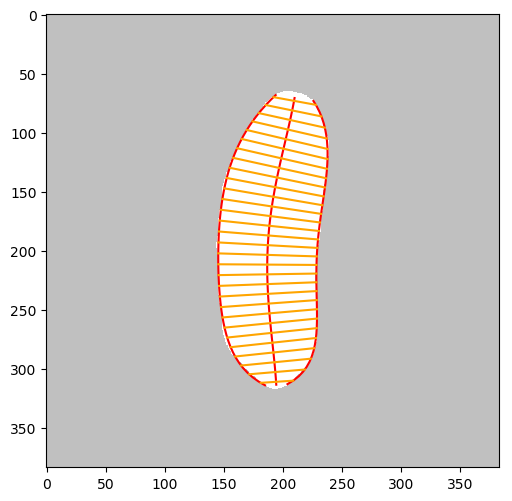

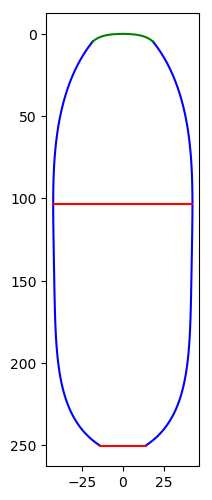

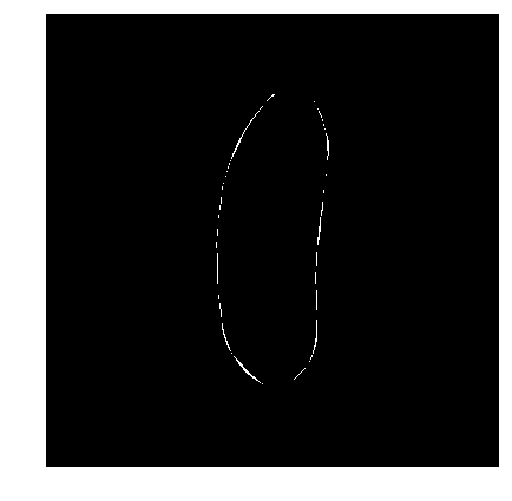

In [4]:
%time
img =imgs[0]  
%time approxAndMeasurement(img,M=4,N=5,C=4,L=5,precPara1=0.05,precPara2=0.01,n_samples=20,n_samples2=30,openmode=False,debugmode=False,showImage=True)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs
仮分割…ベジエあてはめ１…輪郭線左右分割…左輪郭点の数  239 　右輪郭点の数　 252
ベジエあてはめ2…左右平均点へのベジエあてはめ…幅サンプル生成…あてはめ結果表示…延伸形状復元…CAP(近似除外上端部)　20.2
ダイコンの長さ=186.3　　（CAPを含む）
最大直径=168.9 最大直径の位置は、上端から47.8 % の位置
ずれ計算
近似対象の面積は、23535,  輪郭画素数は491,   ずれは、614.0  ピクセル
曲線の方程式
 198*t**5 + 196.896979427853*t**4*(-5*t + 5) + 1872.39420333087*t**3*(-t + 1)**2 + 3525.03386458191*t**2*(-t + 1)**3 + 1311.42400735786*t*(-t + 1)**4 + 246*(-t + 1)**5 
 313*t**5 + 230.031957620973*t**4*(-5*t + 5) + 1979.75066857353*t**3*(-t + 1)**2 + 2786.9376649897*t**2*(-t + 1)**3 + 381.765555075505*t*(-t + 1)**4 + 80*(-t + 1)**5
CPU times: user 3min 29s, sys: 893 ms, total: 3min 30s
Wall time: 3min 32s


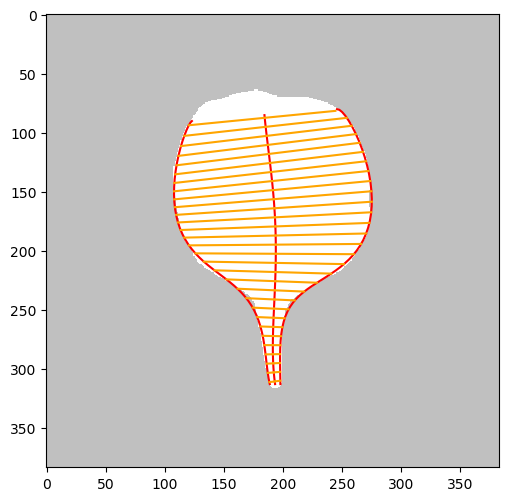

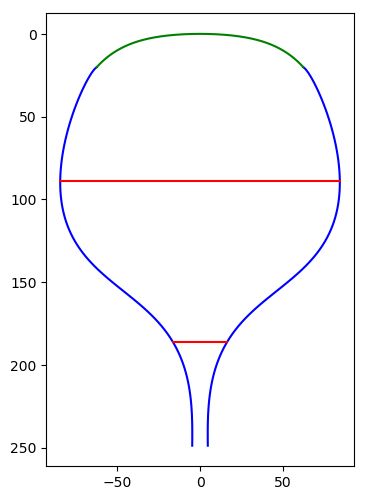

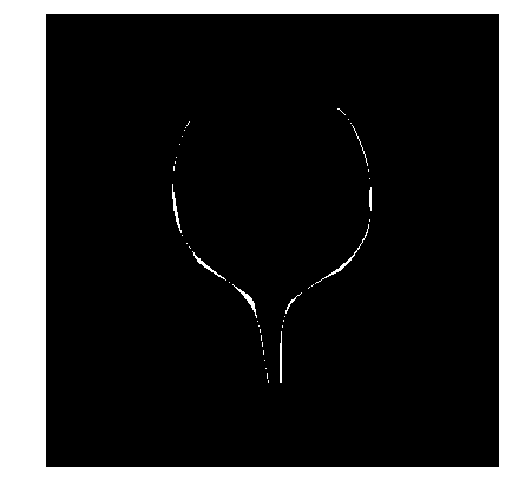

In [5]:
%time
img =imgs[1]  
%time approxAndMeasurement(img,M=4,N=5,C=4,L=5,precPara1=0.05,precPara2=0.01,n_samples=20,n_samples2=30,openmode=False,debugmode=False,showImage=True)

サンプル数　２５、２５の場合

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 14.8 µs
仮分割…ベジエあてはめ１…輪郭線左右分割…左輪郭点の数  239 　右輪郭点の数　 252
ベジエあてはめ2…左右平均点へのベジエあてはめ…幅サンプル生成…あてはめ結果表示…延伸形状復元…CAP(近似除外上端部)　20.8
ダイコンの長さ=185.6　　（CAPを含む）
最大直径=168.9 最大直径の位置は、上端から49.8 % の位置
ずれ計算
近似対象の面積は、23535,  輪郭画素数は491,   ずれは、540.0  ピクセル
曲線の方程式
 198*t**5 + 195.222846762125*t**4*(-5*t + 5) + 1894.09747454508*t**3*(-t + 1)**2 + 3538.91271853538*t**2*(-t + 1)**3 + 1297.99327507702*t*(-t + 1)**4 + 246*(-t + 1)**5 
 313*t**5 + 240.582638462852*t**4*(-5*t + 5) + 1767.39794153114*t**3*(-t + 1)**2 + 3027.37753665909*t**2*(-t + 1)**3 + 316.598979872872*t*(-t + 1)**4 + 80*(-t + 1)**5
CPU times: user 3min 43s, sys: 946 ms, total: 3min 44s
Wall time: 3min 45s


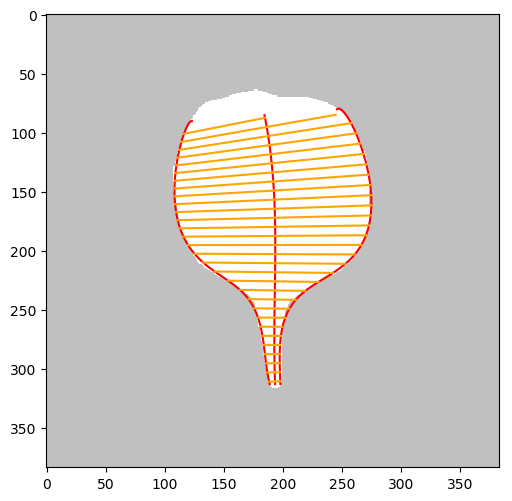

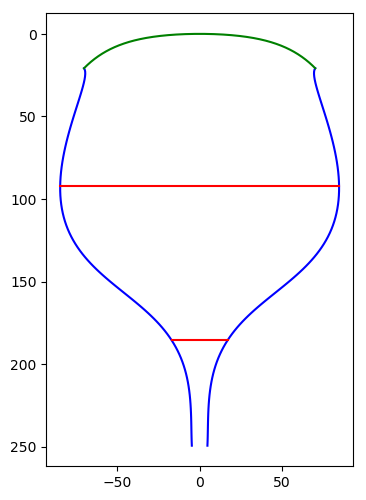

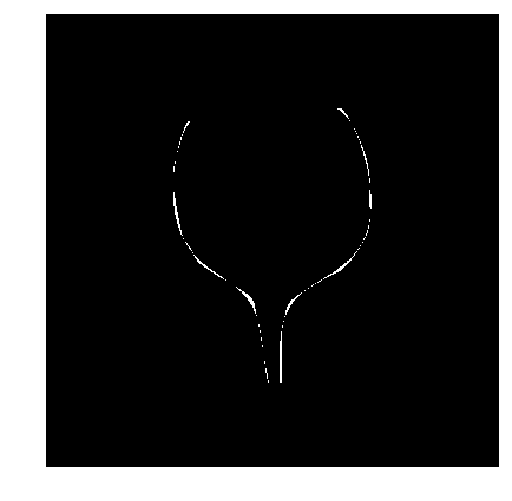

In [6]:
%time
img =imgs[1]  
%time approxAndMeasurement(img,M=4,N=5,C=3,L=5,precPara1=0.05,precPara2=0.01,n_samples=25,openmode=False,debugmode=False,showImage=True)

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 15 µs
仮分割…ベジエあてはめ１…輪郭線左右分割…左輪郭点の数  264 　右輪郭点の数　 252
ベジエあてはめ2…左右平均点へのベジエあてはめ…幅サンプル生成…あてはめ結果表示…延伸形状復元…CAP(近似除外上端部)　19.1
ダイコンの長さ=239.3　　（CAPを含む）
最大直径=123.6 最大直径の位置は、上端から81.6 % の位置
ずれ計算
近似対象の面積は、19319,  輪郭画素数は516,   ずれは、771.0  ピクセル
曲線の方程式
 202*t**5 + 215.575784003315*t**4*(-5*t + 5) + 3456.19107777161*t**3*(-t + 1)**2 + 1743.28971743334*t**2*(-t + 1)**3 + 1251.46203280516*t*(-t + 1)**4 + 243*(-t + 1)**5 
 311*t**5 + 220.292761065445*t**4*(-5*t + 5) + 4272.122109968*t**3*(-t + 1)**2 + 544.108333720148*t**2*(-t + 1)**3 + 879.647507161459*t*(-t + 1)**4 + 88*(-t + 1)**5
CPU times: user 6min 25s, sys: 1.59 s, total: 6min 27s
Wall time: 6min 30s


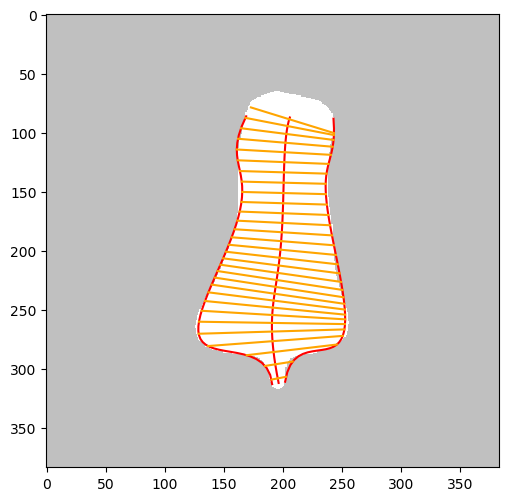

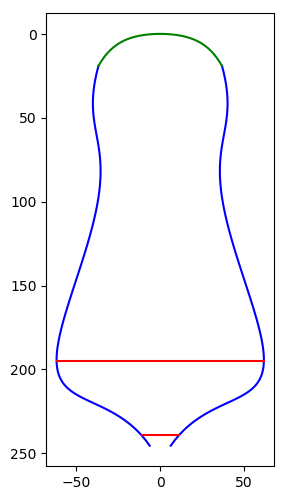

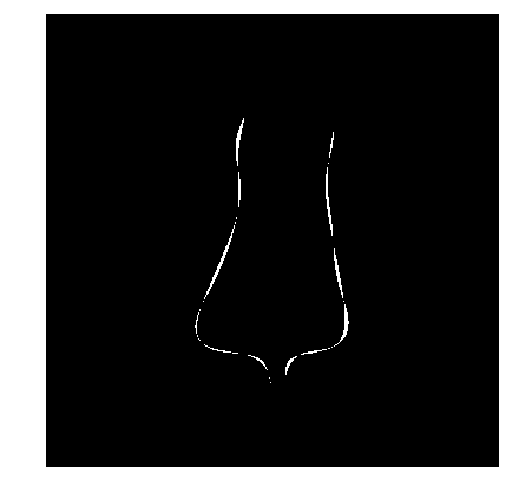

In [7]:
%time
img =imgs[2]  
%time approxAndMeasurement(img,M=4,N=5,C=4,L=5,precPara1=0.05,precPara2=0.01,n_samples=20,n_samples2=30,openmode=False,debugmode=False,showImage=True)

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 15 µs
仮分割…ベジエあてはめ１…輪郭線左右分割…左輪郭点の数  264 　右輪郭点の数　 252
ベジエあてはめ2…左右平均点へのベジエあてはめ…幅サンプル生成…あてはめ結果表示…延伸形状復元…CAP(近似除外上端部)　19.1
ダイコンの長さ=239.3　　（CAPを含む）
最大直径=123.6 最大直径の位置は、上端から81.6 % の位置
ずれ計算
近似対象の面積は、19319,  輪郭画素数は516,   ずれは、771.0  ピクセル
曲線の方程式
 202*t**5 + 215.575784003315*t**4*(-5*t + 5) + 3456.19107777161*t**3*(-t + 1)**2 + 1743.28971743334*t**2*(-t + 1)**3 + 1251.46203280516*t*(-t + 1)**4 + 243*(-t + 1)**5 
 311*t**5 + 220.292761065445*t**4*(-5*t + 5) + 4272.122109968*t**3*(-t + 1)**2 + 544.108333720148*t**2*(-t + 1)**3 + 879.647507161459*t*(-t + 1)**4 + 88*(-t + 1)**5
CPU times: user 2min 34s, sys: 454 ms, total: 2min 35s
Wall time: 2min 36s


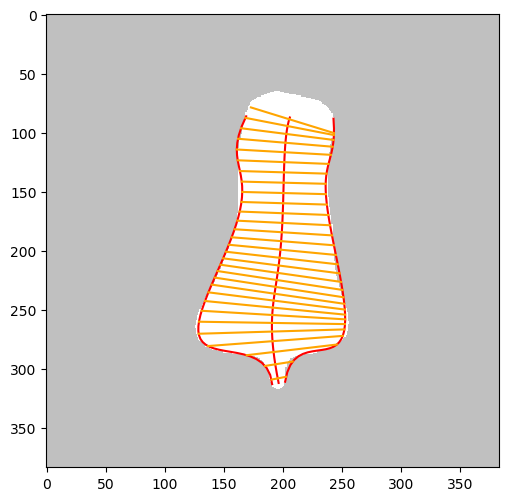

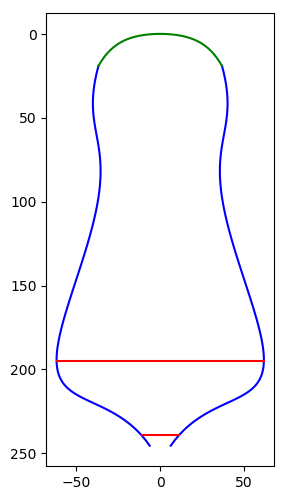

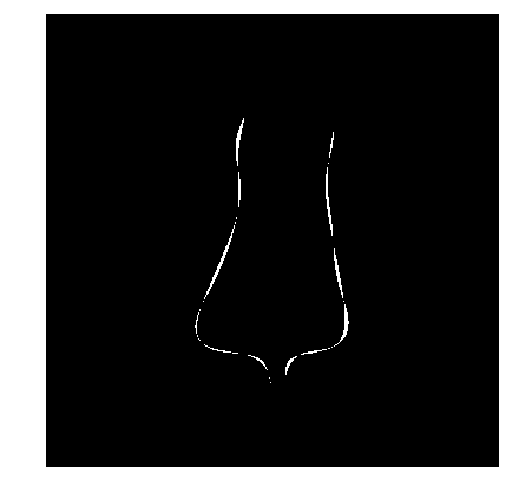

In [8]:
%time
img =imgs[2]  
%time approxAndMeasurement(img,M=4,N=5,C=4,L=5,precPara1=0.05,precPara2=0.01,n_samples=20,n_samples2=30,openmode=False,debugmode=False,showImage=True)

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 15 µs
仮分割…ベジエあてはめ１…輪郭線左右分割…左輪郭点の数  233 　右輪郭点の数　 247
ベジエあてはめ2…左右平均点へのベジエあてはめ…幅サンプル生成…あてはめ結果表示…延伸形状復元…CAP(近似除外上端部)　9.3
ダイコンの長さ=264.7　　（CAPを含む）
最大直径=21.9 最大直径の位置は、上端から15.0 % の位置
ずれ計算
近似対象の面積は、4312,  輪郭画素数は480,   ずれは、406.0  ピクセル
曲線の方程式
 199*t**5 + 204.399063920468*t**4*(-5*t + 5) + 2247.00107563126*t**3*(-t + 1)**2 + 2559.42938145758*t**2*(-t + 1)**3 + 1053.03404181351*t*(-t + 1)**4 + 173*(-t + 1)**5 
 312*t**5 + 259.317479534459*t**4*(-5*t + 5) + 2107.06262384351*t**3*(-t + 1)**2 + 1603.6693899747*t**2*(-t + 1)**3 + 482.05860020693*t*(-t + 1)**4 + 69*(-t + 1)**5
CPU times: user 3min 2s, sys: 653 ms, total: 3min 3s
Wall time: 3min 4s


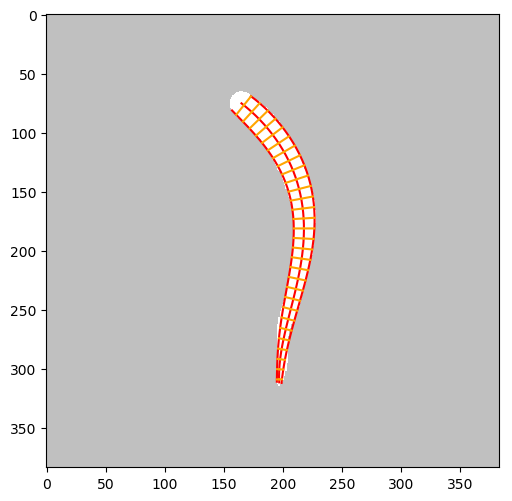

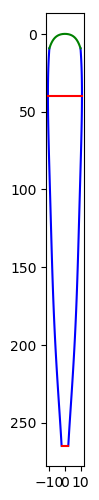

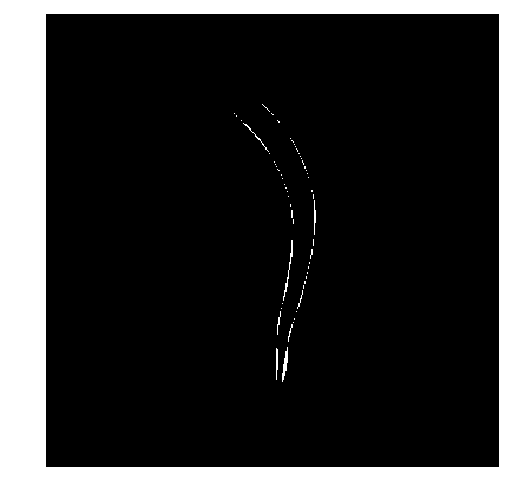

In [9]:
%time
img =imgs[3]  
%time approxAndMeasurement(img,M=4,N=5,C=4,L=5,precPara1=0.05,precPara2=0.01,n_samples=20,n_samples2=30,openmode=False,debugmode=False,showImage=True)

# パラメータ違いの結果

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 16.9 µs
仮分割…ベジエあてはめ１…輪郭線左右分割…左輪郭点の数  263 　右輪郭点の数　 252
ベジエあてはめ2…左右平均点へのベジエあてはめ…幅サンプル生成…あてはめ結果表示…延伸形状復元…CAP(近似除外上端部)　19.3
ダイコンの長さ=241.8　　（CAPを含む）
最大直径=122.5 最大直径の位置は、上端から78.8 % の位置
ずれ計算
近似対象の面積は、19313,  輪郭画素数は515,   ずれは、1176.0  ピクセル
曲線の方程式
 202*t**4 + 304.796725475996*t**3*(-4*t + 4) + 1376.83916447066*t**2*(-t + 1)**2 + 934.266924371584*t*(-t + 1)**3 + 243*(-t + 1)**4 
 311*t**4 + 213.891065608287*t**3*(-4*t + 4) + 2020.03882459446*t**2*(-t + 1)**2 + 400.652110126699*t*(-t + 1)**3 + 88*(-t + 1)**4
CPU times: user 1min 56s, sys: 501 ms, total: 1min 57s
Wall time: 1min 58s


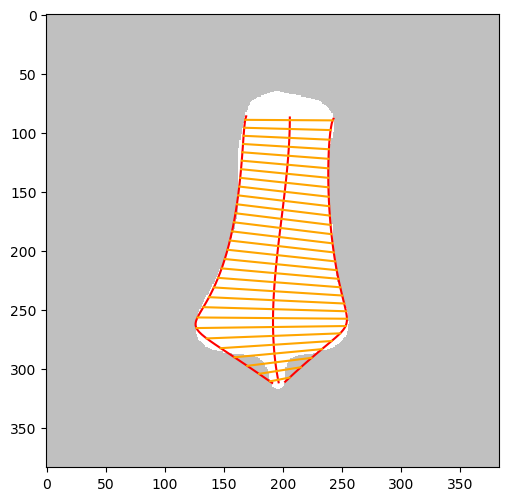

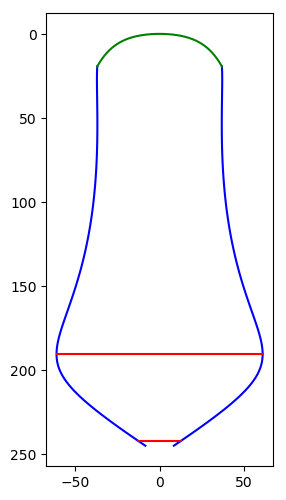

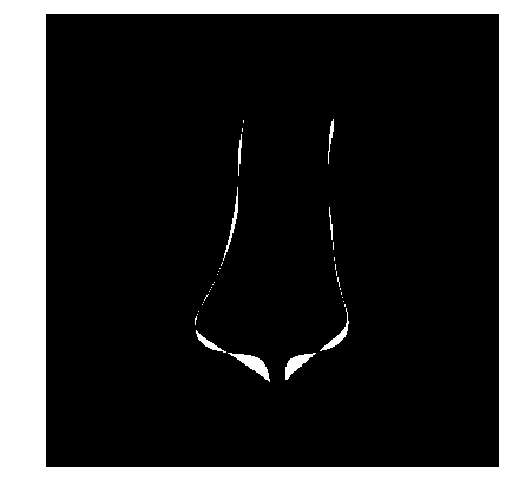

In [10]:
%time
img =imgs[2]  
%time approxAndMeasurement(img,M=3,N=4,C=3,L=4,precPara1=0.05,precPara2=0.01,n_samples=20,n_samples2=30,openmode=False,debugmode=False,showImage=True)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 12.2 µs
仮分割…ベジエあてはめ１…輪郭線左右分割…左輪郭点の数  263 　右輪郭点の数　 251
ベジエあてはめ2…左右平均点へのベジエあてはめ…幅サンプル生成…あてはめ結果表示…延伸形状復元…CAP(近似除外上端部)　19.2
ダイコンの長さ=239.9　　（CAPを含む）
最大直径=119.1 最大直径の位置は、上端から75.3 % の位置
ずれ計算
近似対象の面積は、19308,  輪郭画素数は514,   ずれは、1395.0  ピクセル
曲線の方程式
 202*t**5 + 213.892094348114*t**4*(-5*t + 5) + 3524.0202920521*t**3*(-t + 1)**2 + 1637.34842763756*t**2*(-t + 1)**3 + 1279.62358088798*t*(-t + 1)**4 + 243*(-t + 1)**5 
 310*t**5 + 268.469491709313*t**4*(-5*t + 5) + 2907.17118443643*t**3*(-t + 1)**2 + 1557.50016250256*t**2*(-t + 1)**3 + 743.959267398231*t*(-t + 1)**4 + 88*(-t + 1)**5
CPU times: user 4min 25s, sys: 1.31 s, total: 4min 26s
Wall time: 4min 28s


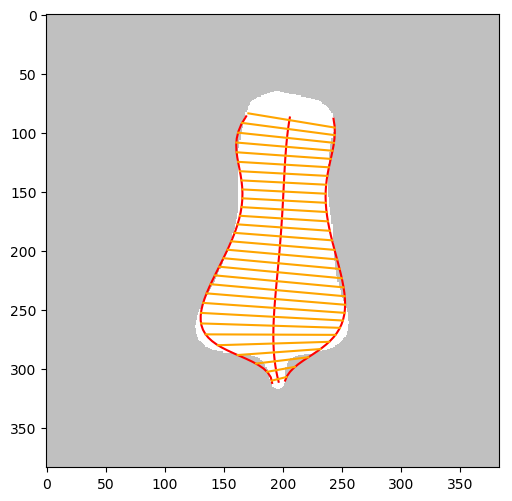

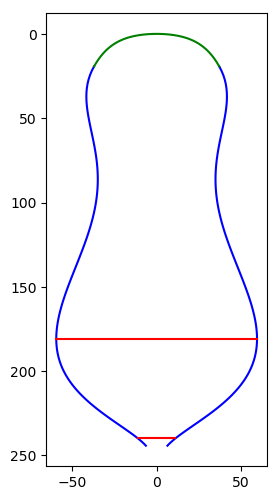

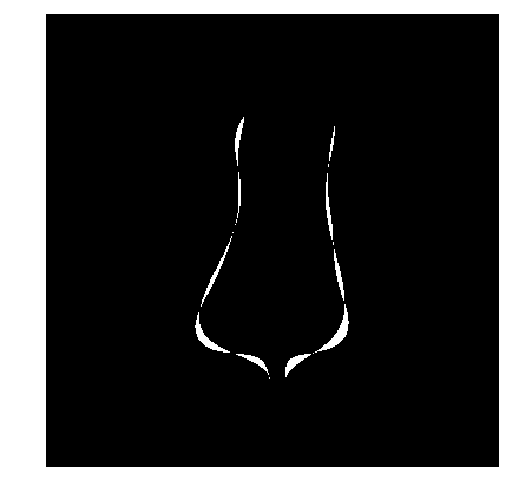

In [11]:
%time
img =imgs[2]  
%time approxAndMeasurement(img,M=4,N=5,C=4,L=5,precPara1=0.1,precPara2=0.1,n_samples=15,n_samples2=30,openmode=False,debugmode=False,showImage=True)

# 解説

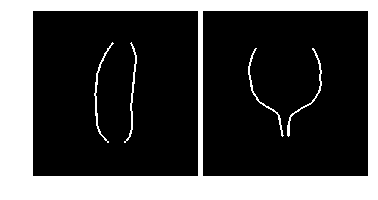

In [12]:
img =imgs[0]
cntl,cntr,cnt = preGetLRdata(img,5,95,bracket=2)
canvas = np.zeros_like(img)
cv2.drawContours(canvas,cntl,-1,255,3)
canvas2 = cv2.drawContours(canvas,cntr,-1,255,3)
img =imgs[1]
cntl,cntr,cnt = preGetLRdata(img,10,90,bracket=2)
canvas = np.zeros_like(img)
cv2.drawContours(canvas,cntl,-1,255,3)
cv2.drawContours(canvas,cntr,-1,255,3)
imshowpara(canvas2,canvas)

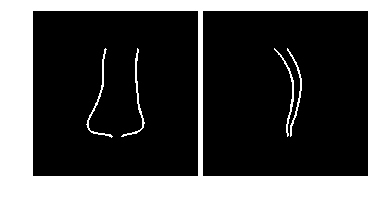

In [13]:
img =imgs[2]
cntl,cntr,cnt = preGetLRdata(img,10,90,bracket=2)
canvas = np.zeros_like(img)
cv2.drawContours(canvas,cntl,-1,255,3)
canvas2 = cv2.drawContours(canvas,cntr,-1,255,3)
img =imgs[3]
cntl,cntr,cnt = preGetLRdata(img,10,90,bracket=2)
canvas = np.zeros_like(img)
cv2.drawContours(canvas,cntl,-1,255,3)
cv2.drawContours(canvas,cntr,-1,255,3)
imshowpara(canvas2,canvas)

# 中心軸の初期近似

# パス１

1. 画像を読み込み、上下方向の５％から９５％の部分を抜き出すことで輪郭点を左右に分ける。
2. 左右それぞれ３次のベジエ曲線で近似し、平均として中心軸をパラメータ表現する。

In [14]:
img =imgs[3]
cntl,cntr,cnt = preGetLRdata(img,5,95,bracket=1)
cpl,cpr,cpc, bezL,bezR,bezC,cntL,cntR = cntPair2bez(cntl,cntr,N=3, precPara=0.1,openmode=False,debugmode=True,showImage=True)

diffpara 0.04862843826413163
diffpara 0.05954394116997727


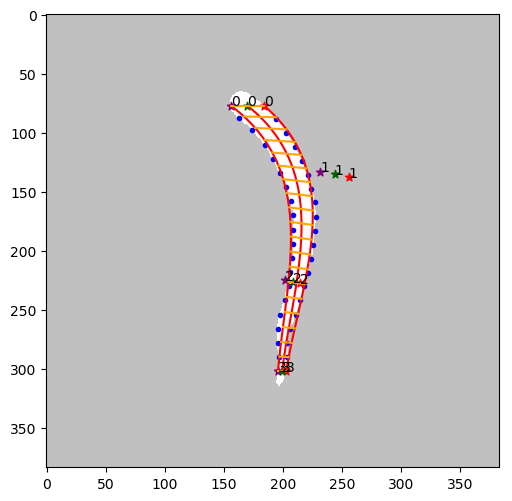

In [15]:
# 結果の表示
drawBez2(img,bezL,bezR,bezC=bezC,cpl=cpl,cpr=cpr,cpc=cpc,cntL=cntL,cntR=cntR,cntC=None, ladder='lr',n_samples=20)

この時点ではズレが大きいが、上下の傾きはほぼ正しく認識できていると考えられる。

## 左右輪郭の再抽出

再度全輪郭を描き、中心軸の延長上に中心をもつ円を黒で描くことで輪郭を左右に分割する。
上下の位置に傾きがあっても比較的良好な分割となる。

左輪郭点の数  233 　右輪郭点の数　 246


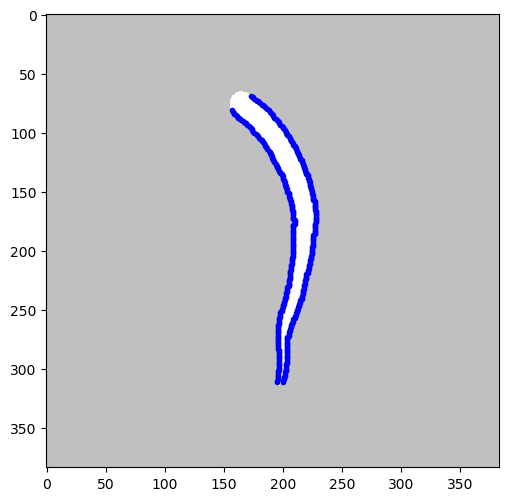

In [20]:
cntl,cntr,_,_ = reGetCntPair(img,cnt,cpl,cpr,bezC)
drawBez2(img,cntL=cntl,cntR=cntr)

# パス２
再抽出された左右輪郭を５次ベジエ曲線で近似する。

In [21]:
cpl,cpr,cpc, bezL,bezR,bezC,cntL,cntR = cntPair2bez(cntl,cntr,N=5,n_samples=25, precPara=0.01, openmode=False,debugmode=True,showImage=True)

diffpara 0.034401249140501106
diffpara 0.004999995231628418
diffpara 0.037980865687131965
diffpara 0.014999985694885254
diffpara 0.0


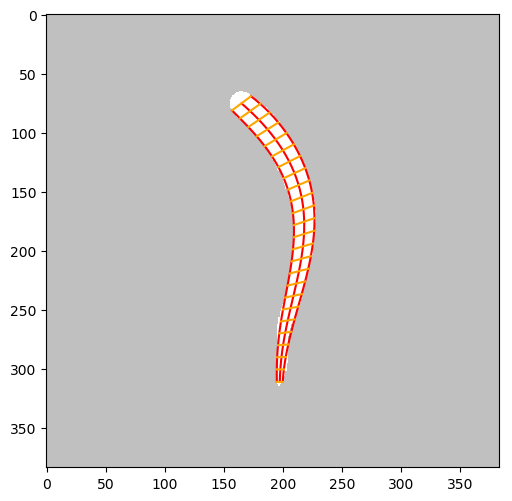

In [22]:
# 結果の表示
drawBez2(img,bezL,bezR,bezC=bezC,ladder='lr',n_samples=25) ;

## 幅の計測
 
 基本的には左右のパラメータ表現の平均はほぼ中心軸に対応すると考えて良いが、上端下端付近の傾きが水平方向から大きくかけ離れた方向になることが多いので、関数に基づいてサンプル点を生成してそれをベジエ曲線で再近似する。

In [24]:
(cpxc,cpyc),[bezXc,bezYc]  = getcenterBez(bezL,bezR,C=4,precPara2=0.01,n_samples = 25, openmode=False,debugmode=True)

diffpara 0.03049382939934739
diffpara 0.005000002682209015


In [25]:
# 結果の表示
PlistL,PlistR,PosL,PosR= calcWidthFunc(bezL,bezR,bezC,n_samples=25)
drawBez2(img,bezL,bezR,bezC=bezC,ladder='normal',PosL=PosL,PosR=PosR,n_samples=25) ;

ValueError: too many values to unpack (expected 4)

In [ ]:
shapeX,shapeY,radishLength, maxDia = shapeReconstruction(cnt,PosL,PosR,bezL,bezR,bezC,cntl,cntr,C=4,precPara=0.01,showImage=True);

In [ ]:
shapeX,shapeY

In [ ]:
canvas1,canvas2,areas = diffCnt2Bez(img,cnt,cntl,cntr,bezL,bezR, showImage=True)

In [ ]:
img =imgs[2]
approxAndMeasurement(img,M=3,N=5,C=4,L=4,precPara1=0.1,precPara2=0.01,n_samples=30,openmode=False,debugmode=False,showImage=True)

In [ ]:
img =imgs[2]
approxAndMeasurement(img,M=3,N=5,C=4,L=3,precPara1=0.05,precPara2=0.01,n_samples=20,openmode=False,debugmode=False,showImage=True)

In [ ]:
img =imgs[2]
approxAndMeasurement(img,M=5,N=5,C=5,L=5,precPara1=0.05,precPara2=0.01,n_samples=20,openmode=False,debugmode=False,showImage=True)

# 研究

In [ ]:
def approxAndMeasurementTest(img,M=4,N=5,C=4,L=5,precPara1=0.05,precPara2=0.01,n_samples=20,n_samples2=30,openmode=False,debugmode=False,showImage=True):
    # フェーズ１　仮中心軸の生成
    print('仮分割…',end='')
    ## 輪郭線を左右に仮分割
    cntl,cntr,cnt = preGetLRdata(img,5,95,bracket=1)
    print('ベジエあてはめ１…',end='')
    ## ベジエ曲線あてはめ（パス１）
    cpl,cpr,cpc, bezL,bezR,bezC,cntL,cntR = cntPair2bez(cntl,cntr,N=M, precPara=precPara1,openmode=openmode,debugmode=debugmode,showImage=showImage)
    print('輪郭線左右分割…',end='')
    ## 中心軸をもとにしてより妥当な左右の輪郭をえる
    cntl,cntr,TopP,_ = reGetCntPair(img,cnt,cpl,cpr,bezC,CAPCUT=0,TAILCUT=0)
    print('ベジエあてはめ2…',end='')
    ## ベジエ曲線あてはめ （パス２）
    cpl,cpr,cpc, bezL,bezR,bezC,cntL,cntR= cntPair2bez(cntl,cntr,N=N,n_samples=n_samples, precPara=precPara2, openmode=openmode,debugmode=debugmode,showImage=showImage)
    print('左右平均点へのベジエあてはめ…',end='')
    ## 中心軸へのベジエあてはめ
    cpc2,bezC2  = getcenterBez(bezL,bezR,C=C,precPara2=precPara2,n_samples = n_samples, openmode=openmode,debugmode=debugmode)
    print('幅サンプル生成…',end='')
    ## 幅のサンプリング
    PlistL,PlistR,PlistC, PosL,PosR,PosC = calcWidthFuncTEST(bezL,bezR,bezC2,n_samples=n_samples2)
    print('あてはめ結果表示…',end='')
    ## 結果の表示
    drawBez2(img,bezL,bezR,bezC=bezC2,ladder='normal',PosL=PosL,PosR=PosR,PosC=PosC, n_samples=n_samples2) 
    print('延伸形状復元…',end='')
    ## 延伸形状復元＆計測
    CPs,shapeX,shapeY,radishLength, maxDia = shapeReconstructionTEST(cnt,PosL,PosR,PosC,bezL,bezR,bezC2,cntl,cntr,C=L,precPara=precPara2,showImage=showImage)
    print('ずれ計算')
    ## 面積のずれの計算
    diffCnt2Bez(img,cnt,cntl,cntr,bezL,bezR, showImage=showImage)

    
# 中心軸の垂直断面幅を求める測定点を求める
def calcWidthFuncTEST(bezL,bezR,bezC,n_samples):
        bezXl,bezYl = bezL
        bezXr,bezYr = bezR
        bezXc,bezYc = bezC
        # 中心軸上に設定したサンプル点における法線と両輪郭の交点のリストを求める。
        PlistL,PlistR,PlistC = [],[],[]
        PosL,PosR,PosC=[],[],[]
        x0,y0 = var('x0,y0')
        for ts in np.linspace(0.01, 0.99, n_samples):
            y0 = float(bezYc.subs(t,ts))
            x0 = float(bezXc.subs(t,ts))
            dx = float(diff(bezXc,t).subs(t,ts)) # x、y をそれぞれ t で微分　傾きを求めようとしている
            dy = float(diff(bezYc,t).subs(t,ts))
            ans = solve(-dx/dy*(bezXr-x0)+y0-bezYr,t) # 法線とベジエ輪郭の交点を求める
            ansR = [re(i) for i in ans if float(Abs(im(i)))<0.00000001] 
            # ↑理論的には、im(i) == 0  でいいのだが、数値計算誤差で虚部が０とならず、微小な値となる現象に現実的な対応
            s = [i for i in ansR if  i<=1.03 and -0.03<=i] # ０から１までの範囲の解を抽出
            PlistR.append(s[0]) if s != [] else PlistR.append(np.inf) 
            PosR.append([float(bezXr.subs(t,s[0])),float(bezYr.subs(t,s[0]))]) if s !=[] else PosR.append([np.inf,np.inf])
            ans = solve(-dx/dy*(bezXl-x0)+y0-bezYl,t) # 法線とベジエ輪郭の交点を求める
            ansL = [re(i) for i in ans if float(Abs(im(i)))<0.00000001]
            s = [i for i in ansL if  i<=1.03 and -0.03<=i]
            PlistL.append(s[0]) if s != [] else PlistL.append(np.inf) 
            PosL.append([float(bezXl.subs(t,s[0])),float(bezYl.subs(t,s[0]))]) if s !=[] else PosL.append([np.inf,np.inf])
            PlistC.append(ts)
            PosC.append([x0,y0])
        return PlistL,PlistR,PlistC,PosL,PosR,np.array(PosC)
    
# 曲がりのない形状を計算する

    # 曲がりのない形状を計算する
def shapeReconstructionTEST(cnt,PosL,PosR,PosC,bezL,bezR,bezC,cntl,cntr,C=4,precPara=0.01,showImage=False):
        bezXl,bezYl = bezL
        bezXr,bezYr = bezR
        bezXc,bezYc = bezC
        n_samples = len(PosL)
        # 中心軸と実輪郭の交点を求めて、上端の削除された長さを求める
        canvas1 = np.zeros_like(img)  # 描画キャンバスの準備
        canvas2 = canvas1.copy()
        canvas1 = cv2.drawContours(canvas1, cnt, -1, 1, thickness=1)     # 輪郭線の描画
        # 中心軸上端から、軸の延長方向に直線を描く
        y0 = float(bezYc.subs(t,0.)) # 上端の座標
        x0 = float(bezXc.subs(t,0.))
        dx = float(diff(bezXc,t).subs(t,0.)) #  　傾きを求めようとしている
        dy = float(diff(bezYc,t).subs(t,0.))
        acc = dy/dx if dx != 0 else np.inf # 傾き
        x1 = x0 - y0/acc if dx !=0 else x0
        y1 = 0
        canvas2 = cv2.line(canvas2,(int(float(x0)),int(float(y0))),(int(float(x1)),int(float(y1))),1,2) # 幅3（2*2-1）の直線を明るさ１で描く
        canvas = canvas1 + canvas2
        cross_points = np.where(canvas==2) # 交点　　　重なった場所は値が２となっている.
        if len(cross_points[0]) != 0 : crosspy,crosspx= np.average(cross_points,axis=1)  # その平均座標
        caplength = 0 if len(cross_points[0]) == 0 else np.sqrt((crosspx-x0)**2+(crosspy-y0)**2) # 削られた分の長さ
        print("\nCAP(近似除外上端部)　{0:0.1f}".format(caplength))
        
        # 近似折れ線の長さの和で定積分を代替する
        SEGN = 1
        fx = [float(bezXc.subs(t,tp)) for tp in np.linspace(0,1,SEGN*n_samples)]
        fy = [float(bezYc.subs(t,tp)) for tp in np.linspace(0,1,SEGN*n_samples)]
        lengthTable = [caplength]
        tlength = caplength
        for index,i in enumerate(np.linspace(0,1,n_samples-1)):
            ii  = SEGN*index
            for n in range(SEGN):
                tlength += np.sqrt((fx[ii+n+1]-fx[ii+n])**2+(fy[ii+n+1]-fy[ii+n])**2)
            lengthTable.append(tlength)
        radiusTable = []
        for i, tpara in enumerate(np.linspace(0,1,n_samples)):
            cx,cy = PosC[i][0],PosC[i][1]
            lx,ly = PosL[i][0],PosL[i][1]
            rx,ry = PosR[i][0],PosR[i][1]
            if lx != np.inf and rx != np.inf:
                ll = np.sqrt(float(lx-cx)**2+float(ly-cy)**2)
                rl = np.sqrt(float(rx-cx)**2+float(ry-cy)**2)
                radishR = (ll+rl)/2 # 半径
            elif lx == np.inf and rx != np.inf:
                rl = np.sqrt(float(rx-cx)**2+float(ry-cy)**2)
                radishR = rl # 半径
            elif lx !=  np.inf and rx == np.inf:
                ll = np.sqrt(float(lx-cx)**2+float(ly-cy)**2)
                radishR = ll # 半径
            else:
                radishR = np.inf
            if radishR != np.inf :
                radiusTable.append([radishR,lengthTable[i]])
        radiusTable = np.array(radiusTable)
 
        #  延伸形状をベジエ曲線で近似
        cpxl,cpyl,shapeX,shapeY,_tpl = fitBezierCurveN(radiusTable,precPara=precPara,N=C)
        # 最大径とその位置を求める
        fx = np.array([float(shapeX.subs(t,i)) for i in np.linspace(0,1,101)]) # 0.01刻み
        fy = np.array([float(shapeY.subs(t,i)) for i in np.linspace(0,1,101)])
        xmax_index = np.argmax(fx)
        maxDia = 2*fx[xmax_index]
        btmline_index = xmax_index + np.argmin((fx[xmax_index:] - maxDia*0.1)**2) # 最大幅の２０％に一番近い幅のインデックス               
        radishLength = fy[btmline_index]
        print("ダイコンの長さ={0:0.1f}　　（CAPを含む）".format(float(radishLength)) )
        print("最大直径={0:0.1f} 最大直径の位置は、上端から{1:0.1f} % の位置".format(maxDia,100*fy[xmax_index]/radishLength))
        
        #結果の描画
        if showImage:
            plt.figure(figsize=(6,6),dpi=100)
            plt.gca().invert_yaxis() 
            plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
            tplins50 = np.linspace(0, 1, 50)

            # 輪郭の描画
            # plotLx = [float(shapeX.subs(t,tp)) for tp in tplins50 ]
            # plotY = [float(shapeY.subs(t,tp)) for tp in tplins50 ]
            ploty = fy
            plotLx = fx
            plotRx = -fx # [-x for x in plotLx]
            plt.plot(plotLx,ploty,color = 'blue')  
            plt.plot(plotRx,ploty,color = 'blue')  
            plt.plot([-fx[xmax_index],fx[xmax_index]],[fy[xmax_index],fy[xmax_index]],color = 'red')
            plt.plot([-fx[btmline_index],fx[btmline_index]],[fy[btmline_index],fy[btmline_index]],color = 'red')
            
            def drawcap(cap, ra = 5):
                magicnumber1=2.063
                magicnumber2=10.59
                x = np.arange(-ra, ra+0.01, 0.01)
                plt.plot(x, cap*(np.cosh(np.pi*x/ra)-1)/magicnumber2,color='green')
            
            drawcap(cap=float(fy[0]),ra=float(fx[0]))
     
        return (cpxl,cpyl),shapeX,shapeY,radishLength, maxDia

In [ ]:
%time
img =imgs[2]  
%time approxAndMeasurementTest(img,M=4,N=5,C=3,L=5,precPara1=0.05,precPara2=0.01,n_samples=20,n_samples2=30,openmode=False,debugmode=False,showImage=True)

In [ ]:
%time
img =imgs[2]  
%time approxAndMeasurementTest(img,M=4,N=5,C=4,L=5,precPara1=0.1,precPara2=0.01,n_samples=20,n_samples2=30,openmode=False,debugmode=False,showImage=True)

In [ ]:
%time
img =imgs[3]  
%time approxAndMeasurementTest(img,M=4,N=5,C=4,L=5,precPara1=0.1,precPara2=0.01,n_samples=20,n_samples2=30,openmode=False,debugmode=False,showImage=True)

In [ ]:
    img=imgs[2]
    M=4
    N=5
    C=3
    L=5
    precPara1=0.1
    precPara2=0.01
    n_samples=20
    n_samples2=30
    openmode=False
    debugmode=False
    showImage=True
    # フェーズ１　仮中心軸の生成
    print('仮分割…',end='')
    ## 輪郭線を左右に仮分割
    cntl,cntr,cnt = preGetLRdata(img,5,95,bracket=1)
    print('ベジエあてはめ１…',end='')
    ## ベジエ曲線あてはめ（パス１）
    cpl,cpr,cpc, bezL,bezR,bezC,cntL,cntR = cntPair2bez(cntl,cntr,N=M, precPara=precPara1,openmode=openmode,debugmode=debugmode,showImage=showImage)
    print('輪郭線左右分割…',end='')
    ## 中心軸をもとにしてより妥当な左右の輪郭をえる
    cntl,cntr,TopP,_ = reGetCntPair(img,cnt,cpl,cpr,bezC,CAPCUT=0,TAILCUT=0)
    print('ベジエあてはめ2…',end='')
    ## ベジエ曲線あてはめ （パス２）
    cpl,cpr,cpc, bezL,bezR,bezC,cntL,cntR= cntPair2bez(cntl,cntr,N=N,n_samples=n_samples, precPara=precPara2, openmode=openmode,debugmode=debugmode,showImage=showImage)
    print('左右平均点へのベジエあてはめ…',end='')
    ## 中心軸へのベジエあてはめ
    cpc2,bezC2  = getcenterBez(bezL,bezR,C=C,precPara2=precPara2,n_samples = n_samples, openmode=openmode,debugmode=debugmode)
    print('幅サンプル生成…',end='')
    ## 幅のサンプリング
    PlistL,PlistR,PlistC, PosL,PosR,PosC = calcWidthFuncTEST(bezL,bezR,bezC2,n_samples=n_samples2)
    print('あてはめ結果表示…',end='')
    ## 結果の表示
    drawBez2(img,bezL,bezR,bezC=bezC2,ladder='normal',PosL=PosL,PosR=PosR,PosC=PosC, n_samples=n_samples2) 
    print('延伸形状復元…',end='')
    ## 延伸形状復元＆計測
    CPs,shapeX,shapeY,radishLength, maxDia = shapeReconstruction(cnt,PosL,PosR,PosC,bezL,bezR,bezC2,cntl,cntr,C=L,precPara=precPara2,showImage=showImage)
    print('ずれ計算')
    ## 面積のずれの計算
    diffCnt2Bez(img,cnt,cntl,cntr,bezL,bezR, showImage=showImage)


In [ ]:
preGetLRdata(img,tlevel = 10, blevel=90,bracket=1)

In [ ]:
plt.imshow(img)

In [ ]:
plt.imshow(imgs[4])

In [ ]:
imgs

In [ ]:
def getstandardShape1(src, unitSize=UNIT,showResult=False):
    # 重心と先端の位置を調べる
    c_x,c_y,t_x,t_y = getCoGandTip1(src,showResult=True)
    deg = getDegreeOfALine(c_x,c_y,t_x,t_y)
    # 重心と先端を結ぶラインがY軸となるように回転し余白はカット
    
    print(c_x,c_y,deg-90)
    
    img = roteteAndCutMargin(src,deg-90,c_x,c_y)

    plt.imshow(img)
    
    # 大きさを標準化したいが、無駄に根が長いと相対的に重要部分が小さくなるのでまず根を削る
    # 作業用のマージンを確保
    img5 = makemargin(img) 
    if showResult: refimg = img5.copy() # 確認用元画像
    # 少し形を整えておく RDreform は上の方で定義してある
    img5 = RDreform1(img5)
    

    # 最大面積の領域を抜き出す。ゴミ領域があるかもしれないので念のため。
    _nLabels, labelImages, data, _center = cv2.connectedComponentsWithStats(img5)
    img5 = img5[data[1][1]:data[1][1]+data[1][3],data[1][0]:data[1][0]+data[1][2]]
    if showResult: refimg = refimg[data[1][1]:,data[1][0]:data[1][0]+data[1][2]]

    '''
    # 重心より上部分の重心の位置と、重心の高さでのシルエット断面の中心を求める
    uc_x,uc_y,d_x,d_y = getUpperCoGandCoC(img5)
    # 重心(c_x,c_y)と上半分の重心(uc_x,uc_y)結ぶ直線の角度を計算する
    deg2 = getDegreeOfALine(uc_x,uc_y,d_x,d_y)
    # 上半分の重心が重心の真上に来るように画像を回転し、余白を削る
    img5 = roteteAndCutMargin(img5,deg2-90,uc_x,uc_y)    
    '''    
    # 長辺が UNIT ピクセルになるよう縮小し、(1.5xUNIT)x(1.5xUNIT)の画像の中央に配置する。
    h,w = img5.shape[:2]
    s_r = UNIT/w if w > h else UNIT/h #  縮小率    
    rsh,rsw = int(s_r*h),int(s_r*w) # リサイズ後のサイズ
    x0 = int((1.5*UNIT-rsw)/2) # はめ込みの基準点
    y0 = int((1.5*UNIT-rsh)/2)
    canvas = np.zeros((int(1.5*UNIT),int(1.5*UNIT)),np.uint8) # キャンバスの確保
    canvas[y0:y0+rsh,x0:x0+rsw] = cv2.resize(img5,(rsw,rsh)) # リサイズして中央にはめ込み

    # 確認用画像も同じリサイズを適用　確認用の場合は尻尾の部分を残して表示したいので少し面倒
    if showResult: 
        refimg2 = np.zeros((int(1.5*UNIT),int(1.5*UNIT)),np.uint8)
        refimg = cv2.resize(refimg,(rsw,int(s_r*refimg.shape[0])))
        if int(1.5*UNIT) - y0 > refimg.shape[0]:
            refimg2[y0:y0+refimg.shape[0],x0:x0+rsw] = refimg
        else:
            refimg2[y0:int(1.5*UNIT),x0:x0+rsw] = refimg[0:int(1.5*UNIT)-y0,:]
            
    # 最後にもう一度だけガウスぼかしを適用してシルエットを滑らかにする
    ksize = 2*int((GAUSSIAN_RATE2*UNIT)/2)+1 # ぼかし量  元の図形の幅に応じて決める
    canvas = cv2.GaussianBlur(canvas,(ksize,ksize),0) # ガウスぼかしを適用
    _ret,resultimg = cv2.threshold(canvas, 128, 255, cv2.THRESH_BINARY) # ２値化

    if showResult:
        plt.figure(figsize=(7,10),dpi=100)
        plt.imshow(draw2(refimg2,resultimg))
        
    return resultimg

In [ ]:
img = cv2.imread(daruma,cv2.IMREAD_GRAYSCALE)
testimg = getstandardShape1(img, unitSize=UNIT,showResult=True)  

In [ ]:
 plt.imshow(roteteAndCutMargin(img,10,0,0))

In [ ]:
GAUSSIAN_RATE1= 0.25

def getCoGandTip1(src, showResult=False, useOldImage=True):
    # useOldImage = True なら元の画像を使って結果を表示、Falseなら滑らかにした画像
    img = makemargin(src) # 作業用のマージンを確保
    img2 = img.copy() # 加工前の状態を保存
    # ガウスぼかしを適用してシルエットを滑らかにする
    ksize = int(GAUSSIAN_RATE1*img.shape[1]/2)*2+1 # ぼかし量  元の図形の幅に応じて決める
    img = cv2.GaussianBlur(img,(ksize,ksize),0) # ガウスぼかしを適用
    # ２値化してシルエットを求め直す
    _ret,img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY) # ２値化
    # Harris コーナ検出
    himg = np.float32(img)
    himg = cv2.cornerHarris(himg,blockSize=3,ksize=3,k=0.04)
    
    plt.figure(figsize=(6,6),dpi=100)
    plt.imshow(himg)
    
    # コーナー度合いが最大の領域を求める
    wimg = np.zeros_like(img)
    wimg[himg>=HARRIS_PARA*himg.max()]=255 # コーナー度最大値の領域を２５５で塗りつぶす。
    # 最大値に等しい値の領域が１点とは限らないし、いくつかの点の塊になるかもしれない
    _lnum, _img, cnt, cog = cv2.connectedComponentsWithStats(wimg)
    areamax = np.argmax(cnt[1:,4])+1 # ０番を除く面積最大値のインデックス
    t_x,t_y = np.round(cog[areamax]) # 重心の位置

    # コア全体の重心の位置を求める
    _lnum, _img, _cnt, cog = cv2.connectedComponentsWithStats(img)
    c_x,c_y = np.round(cog[1])

    # コーナーの場所のマーキング（デバッグ用）
    # himg = cv2.dilate(himg,None,iterations = 3)
    # img3[himg>=HARRIS_PARA*himg.max()]=[0,0,255]

    if showResult: # 
        if useOldImage:
            img3 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
        else:
            img3 = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
        plt.figure(figsize=(10,7),dpi=75)
        img3=cv2.circle(img3,(int(t_x),int(t_y)),5,(0,255,0),2)
        img3=cv2.circle(img3,(int(c_x),int(c_y)),5,(255,255,0),2)
        x1,y1,x2,y2= getTerminalPsOnLine(c_x,c_y,t_x,t_y)
        img3=cv2.line(img3,(x1,y1),(x2,y2),(255,0,255),2)                 
        img3 = cv2.cvtColor(img3,cv2.COLOR_BGR2RGB)
        plt.subplot(122), plt.imshow(img3)
        plt.show()
        
    # 結果を返す (c_x,c_y) 重心　　(t_x,t_y)  先端の位置 img2 滑らかになったシルエット画像
    return c_x,c_y,t_x,t_y


In [ ]:
# (8) ガウスぼかし、膨張収縮、輪郭近似で形状を整える関数
# 形状の細かな変化をガウスぼかし等でなくして大まかな形状にする関数
def RDreform1(img,ksize=5,shrink=SHRINK):
    # ガウスぼかしを適用してシルエットを滑らかにする
    img2 = cv2.GaussianBlur(img,(ksize,ksize),0) # ガウスぼかしを適用
    _ret,img2 = cv2.threshold(img2, 127, 255, cv2.THRESH_BINARY) # ２値化
    # 収縮・膨張によりヒゲ根を除去する
    area0 = np.sum(img2) # img2 の画素数*255 になるはず
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(ksize,ksize)) # 円形カーネル
    tmpimg = cv2.erode(img2,kernel,iterations = 1) # 収縮１回目
    area1 = np.sum(tmpimg) # 収縮したので area0 より少なくなる
    n = 1
    while area1  > shrink*area0: # 面積が SHRINK倍以下になるまで繰り返す
        tmpimg = cv2.erode(tmpimg,kernel,iterations = 1)
        area1 = np.sum(tmpimg) 
        n += 1
    img3 = cv2.dilate(tmpimg,kernel,iterations = n) # 同じ回数膨張させる
    # あらためて輪郭を求め直す
    # まず最大の領域を取り出す
    
    _lnum, labelimg, cnt, _cog =cv2.connectedComponentsWithStats(img3)
    areamax = np.argmax(cnt[1:,4])+1 # ０番を除く面積最大値のインデックス
    img3 = np.zeros_like(img3)
    img3[labelimg==areamax]=255
    _img,cnt,hierarchy = cv2.findContours(img3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
    outimg = np.zeros_like(img3)
    # outimg = cv2.drawContours(outimg, cnt, 0, 255, thickness=-1) 
    # 近似輪郭を求めて描きなおす
    # area = cv2.contourArea(cnt[0]) # 面積
    perimeter = cv2.arcLength(cnt[0],True) # 周囲長
    epsilon = CONTOURS_APPROX*perimeter # 周囲長をもとに精度パラメータを決定
    # 概形抽出
    approx = cv2.approxPolyDP(cnt[0],epsilon,True)
    outimg = cv2.drawContours(outimg, [approx], 0, 255, thickness=-1) 

    return outimg

In [ ]:
darumaimg = getstandardShape(cv2.imread(daruma,cv2.IMREAD_GRAYSCALE), unitSize=UNIT,showResult=True)  

In [ ]:
roteteAndCutMargin(img,0,10,0);

In [ ]:
# (10) 回転した上でマージンをカットした画像を返す
def roteteAndCutMargin(img,deg,c_x,c_y): 
    # 非常に稀であるが、回転すると全体が描画領域外に出ることがあるので作業領域を広く確保
    # mat = cv2.getRotationMatrix2D((x0,y0), deg-90, 1.0) # アフィン変換マトリクス
    bigimg = makemargin(img,mr=10) # 作業用のマージンを確保
    h3,w3 = img.shape[:2]
    h4,w4 = bigimg.shape[:2]

    
    if deg != 0:
        print("AAA")
        mat = cv2.getRotationMatrix2D((c_x+(w4-w3)/2,c_y+(h4-h3)/2), deg, 1.0) # アフィン変換マトリクス
        # アフィン変換の適用
        bigimg = cv2.warpAffine(bigimg, mat, (0,0),1)

    plt.imshow(bigimg)

    # 再び最小矩形を求めて切り出す。ただし、マージンを５つける
    _nLabels, _labelImages, data, _center = cv2.connectedComponentsWithStats(bigimg) 
    areamax = np.argmax(data[1:,4])+1 
    resultimg = bigimg[data[areamax][1]-5:data[areamax][1]+data[areamax][3]+5,data[areamax][0]-5:data[areamax][0]+data[areamax][2]+5]

    return resultimg

In [ ]:
plt.imshow(img)